# Homework 2 (Due on Feb 25, 11:59 PM HKT)
*This notebook includes both coding and written questions. Please hand in this notebook file with all the outputs and your answers to the written questions.*

This assignment covers Canny edge detector, Harris corner detector, and Hough transform.

In [1]:
### Setup

from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'csci3330/hw2'
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from time import time
from skimage import io

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Mounted at /content/drive
/content/drive/My Drive/csci3330/hw2


## Part 1: Canny Edge Detector (65 points)
In this part, you are going to implement a Canny edge detector. The Canny edge detection algorithm can be broken down in to five steps:
1. Smoothing
2. Finding gradients
3. Non-maximum suppression
4. Double thresholding
5. Edge tracking by hysterisis

### 1.1 Smoothing (10 points)


#### Implementation (5 points)
We first smooth the input image by convolving it with a Gaussian kernel. The equation for a Gaussian kernel of size $(2k+1)\times(2k+1)$ is given by:

$$h_{ij}=\frac{1}{2\pi\sigma^2}\exp{\Bigl(-\frac{(i-k)^2+(j-k)^2}{2\sigma^2}\Bigr)}, 0\leq i,j < 2k+1$$

Implement **`gaussian_kernel`** and **`conv`** in `edge.py` and run the code below.

In [2]:
# You should implement gaussian_kernel() and conv() before running this block
from edge import gaussian_kernel, conv

# Define 3x3 Gaussian kernel with std = 1
kernel = gaussian_kernel(3, 1)
kernel_test = np.array(
    [[ 0.05854983, 0.09653235, 0.05854983],
     [ 0.09653235, 0.15915494, 0.09653235],
     [ 0.05854983, 0.09653235, 0.05854983]]
)

kernel_test = kernel_test / np.sum(kernel_test)

# Test Gaussian kernel
if not np.allclose(kernel, kernel_test):
    print('Incorrect values! Please check your implementation.')
else:
    print('Seems correct.')

Seems correct.


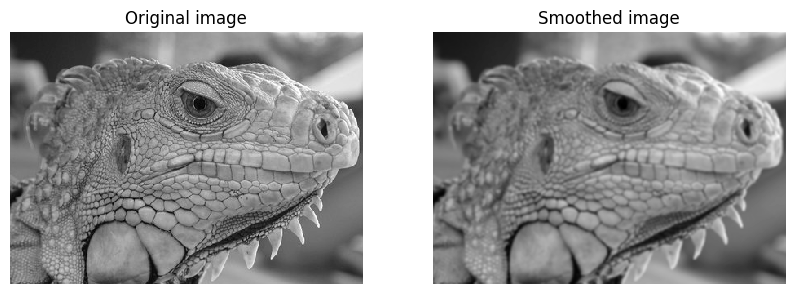

In [3]:
# Test with different kernel_size and sigma
# and describe your observation in the following question
kernel_size = 5  # Kernel size should be odd
sigma = 1.4

# Load image
img = io.imread('data/iguana.png', as_gray=True)

# Define Gaussian kernel with size==kernel_size and std==sigma
kernel = gaussian_kernel(kernel_size, sigma)

# Convolve image with kernel to achieve smoothed effect
smoothed = conv(img, kernel)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(smoothed)
plt.title('Smoothed image')
plt.axis('off')

plt.show()

#### Question (5 points)
What is the effect of changing kernel_size and sigma in the above code block?

**Your Answer Here:** Write your solution in this markdown cell.

Changing sigma and kernel size will affect the smoothness of the output image.

Increasing the kernel_size will result in a larger kernel matrix, increasing sigma will result in a broader and smoother Gaussian curve, and vice versa.

So increasing the kernel size or sigma can result in a smoother image, and decreasing the kernel size and sigma can result in a clearer image.

Also, increasing kernel size will lead to a longer processing time since more multiplication and addition is needed in convolution.

### 1.2 Finding gradients (15 points)
The gradient of a 2D scalar function $I:\mathbb{R}^2\rightarrow{\mathbb{R}}$ in Cartesian coordinate is defined by:

$$\nabla{I(x,y)}=\bigl[\frac{\partial{I}}{\partial{x}},\frac{\partial{I}}{\partial{y}}\bigr],$$

where

$$
\frac{\partial{I(x,y)}}{\partial{x}}=\lim_{\Delta{x}\to{0}}\frac{I(x+\Delta{x},y)-I(x,y)}{\Delta{x}} \\
\frac{\partial{I(x,y)}}{\partial{y}}=\lim_{\Delta{y}\to{0}}\frac{I(x,y+\Delta{y})-I(x,y)}{\Delta{y}}.
$$

In case of images, we can approximate the partial derivatives by taking differences at one pixel intervals:

$$
\frac{\partial{I(x,y)}}{\partial{x}}\approx{\frac{I(x+1,y)-I(x-1,y)}{2}} \\
\frac{\partial{I(x,y)}}{\partial{y}}\approx{\frac{I(x,y+1)-I(x,y-1)}{2}}
$$

Note that the partial derivatives can be computed by convolving the image $I$ with some appropriate kernels $D_x$ and $D_y$:

$$
\frac{\partial{I}}{\partial{x}}\approx{I*D_x}=G_x \\
\frac{\partial{I}}{\partial{y}}\approx{I*D_y}=G_y
$$

#### Implementation (5 points)
Find the kernels $D_x$ and $D_y$ and implement **`partial_x`** and **`partial_y`** using `conv` defined in `edge.py`.

*-Hint: Remeber that convolution flips the kernel.*

In [ ]:
# You should implement partial_x() and partial_y() before running this block
from edge import partial_x, partial_y

# Test input
I = np.array(
    [[0, 0, 0],
     [0, 1, 0],
     [0, 0, 0]]
)

# Expected outputs
I_x_test = np.array(
    [[ 0, 0, 0],
     [ 0.5, 0, -0.5],
     [ 0, 0, 0]]
)

I_y_test = np.array(
    [[ 0, 0.5, 0],
     [ 0, 0, 0],
     [ 0, -0.5, 0]]
)

# Compute partial derivatives
I_x = partial_x(I)
I_y = partial_y(I)

# Test correctness of partial_x and partial_y
if not np.all(I_x == I_x_test):
    print('partial_x incorrect')
else:
    print('partial_x seems correct')

if not np.all(I_y == I_y_test):
    print('partial_y incorrect')
else:
    print('partial_y seems correct')



partial_x seems correct
partial_y seems correct


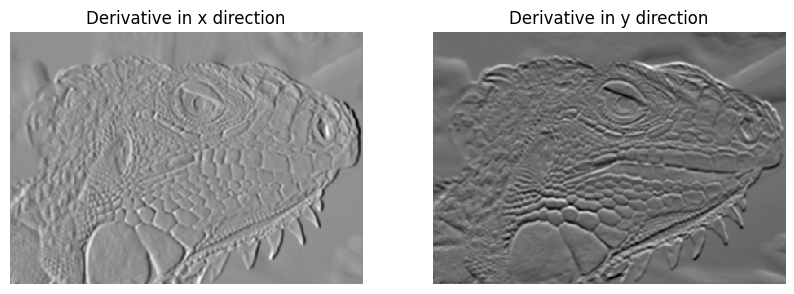

In [ ]:
# Compute partial derivatives of smoothed image
# Here we assume the smoothed image is processed with the following params:
#   >> kernel_size = 5, sigma = 1.4
# If you modified the two parameters above for testing in Q1.1,
#  you need to change it back to the default values (kernel_size = 5, sigma = 1.4)
Gx = partial_x(smoothed)
Gy = partial_y(smoothed)

plt.subplot(1,2,1)
plt.imshow(Gx)
plt.title('Derivative in x direction')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(Gy)
plt.title('Derivative in y direction')
plt.axis('off')

plt.show()

#### Question (5 points)
What is the reason for performing smoothing prior to computing the gradients?

**Your Answer Here:** Write your solution in this markdown cell.

First, performing smoothing can smooth out the noise in the image. After smoothing the intensity value of the noisy pixels will be averaged to be similar to surrounding pixels, making the gradient at that region to be small, so that the computation will be less sensitive to noise.

Also, smoothing can smooth out local variations. For example, minor intensity changes on the iguana skin will be partly smoothed out and only the major edges (such as the contour of the iguana) will be preserved.

#### Implementation (5 points)
Now, we can compute the magnitude and direction of gradient with the two partial derivatives:

$$
G = \sqrt{G_{x}^{2}+G_{y}^{2}} \\
\Theta = arctan\bigl(\frac{G_{y}}{G_{x}}\bigr)
$$

Implement **`gradient`** in `edge.py` which takes in an image and outputs $G$ and $\Theta$.

Magnitude of gradients seems correct.
Direction of gradients seems correct.


(-0.5, 432.5, 309.5, -0.5)

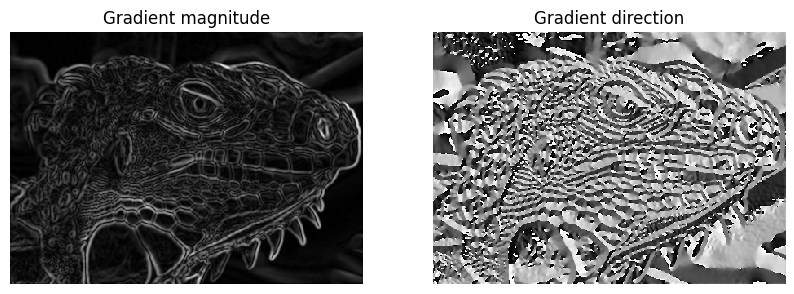

In [ ]:
# You should implement gradient() before running this block
from edge import gradient

G, theta = gradient(smoothed)

if not np.all(G >= 0):
    print('Magnitude of gradients should be non-negative.')
else:
    print('Magnitude of gradients seems correct.')

if not np.all((theta >= 0) * (theta < 360)):
    print('Direction of gradients should be in range 0 <= theta < 360')
else:
    print('Direction of gradients seems correct.')




plt.subplot(1,2,1)
plt.imshow(G)
plt.title('Gradient magnitude')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(theta)
plt.title('Gradient direction')
plt.axis('off')

### 1.3 Edge Thining using Non-maximum Suppression
You should be able to see that the edges extracted from the gradient of the smoothed image are quite thick and blurry. The purpose of this step is to convert the "blurred" edges into "thin" and "sharp" edges. Basically, this is done by preserving all local maxima in the gradient image and discarding everything else. The algorithm is for each pixel (x,y) in the gradient image:
1. Round the gradient direction $\Theta[y,x]$ to the nearest 45 degrees, corresponding to the use of an 8-connected neighbourhood.

2. Compare the edge strength of the current pixel with the edge strength of the pixel in the positive and negative gradient directions. For example, if the gradient direction is south (theta=90), compare with the pixels to the north and south.

3. If the edge strength of the current pixel is the largest; preserve the value of the edge strength. If not, suppress (i.e. remove) the value.

Here we provide an modified version of non-maximum suppression for this task and you do not need to implement it. Run the following block to see the result.

In [ ]:
from edge import edge_thinning

# Test input
g = np.array(
    [[0.4, 0.5, 0.6],
     [0.3, 0.5, 0.7],
     [0.4, 0.5, 0.6]]
)

# Print out the edge_thinning output
for angle in range(0, 180, 45):
    # varying theta
    print('Thetas:', angle)
    t = np.ones((3, 3)) * angle # Initialize theta
    print(edge_thinning(g, t))

Thetas: 0
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Thetas: 45
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Thetas: 90
[[0.  0.  0. ]
 [0.  0.5 0. ]
 [0.  0.  0. ]]
Thetas: 135
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


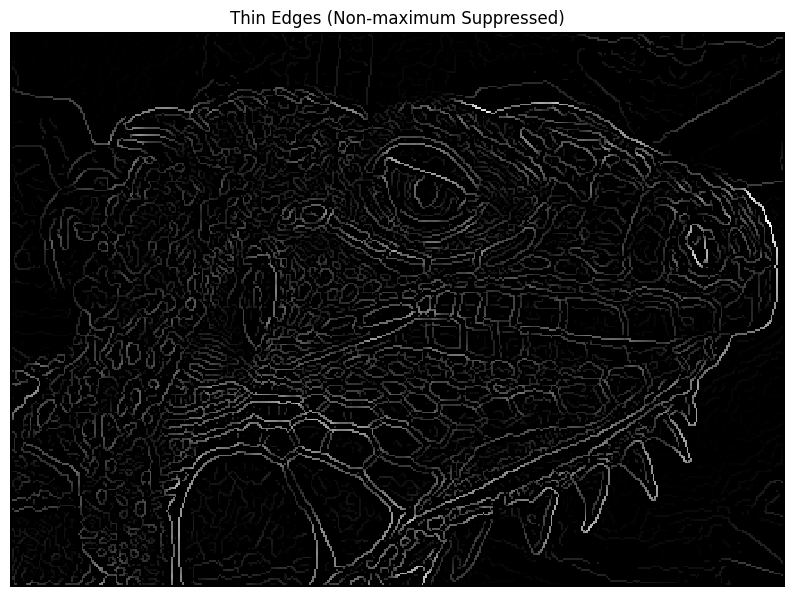

In [ ]:
nms = edge_thinning(G, theta)
plt.imshow(nms)
plt.title('Thin Edges (Non-maximum Suppressed)')
plt.axis('off')
plt.show()

### 1.4 Double Thresholding (10 points)

The edge-pixels remaining after the non-maximum suppression step are (still) marked with their strength pixel-by-pixel. Many of these will probably be true edges in the image, but some may be caused by noise or color variations, for instance, due to rough surfaces. The simplest way to discern between these would be to use a threshold, so that only edges stronger that a certain value would be preserved. The Canny edge detection algorithm uses double thresholding. Edge pixels stronger than the high threshold are marked as strong; edge pixels weaker than the low threshold are suppressed and edge pixels between the two thresholds are marked as weak.

Implement **`double_thresholding`** in `edge.py`

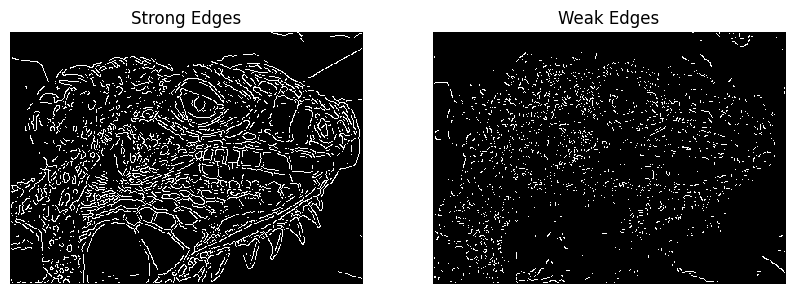

In [ ]:
# You should implement double_thresholding() before running this block
from edge import double_thresholding

low_threshold = 0.02
high_threshold = 0.03

strong_edges, weak_edges = double_thresholding(nms, high_threshold, low_threshold)
assert(np.sum(strong_edges & weak_edges) == 0)

plt.subplot(1,2,1)
plt.imshow(strong_edges)
plt.title('Strong Edges')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(weak_edges)
plt.title('Weak Edges')
plt.axis('off')

plt.show()

### 1.5 Edge tracking (10 points)

Strong edges are interpreted as “certain edges”, and can immediately be included in the final edge image. Weak edges are included if and only if they are connected to strong edges. The logic is of course that noise and other small variations are unlikely to result in a strong edge (with proper adjustment of the threshold levels). Thus strong edges will (almost) only be due to true edges in the original image. The weak edges can either be due to true edges or noise/color variations. The latter type will probably be distributed independently of edges on the entire image, and thus only a small amount will be located adjacent to strong edges. Weak edges due to true edges are much more likely to be connected directly to strong edges.

Implement **`link_edges`** in `edge.py`.

We provide a reference output and the difference between it and your result for debugging purposes.  If you notice your result is too different from the reference output, you should check your implementation.

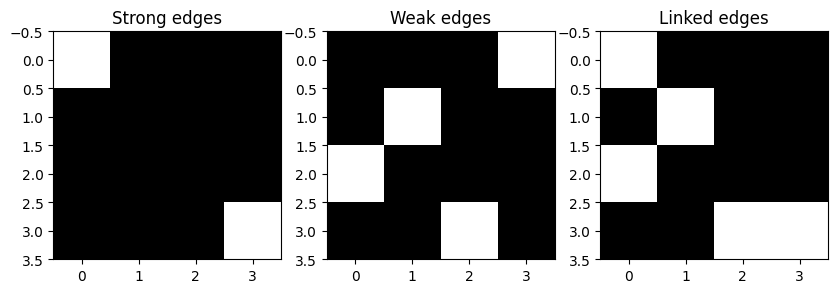

In [ ]:
from edge import get_neighbors, link_edges

test_strong = np.array(
    [[1, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 1]],
    dtype=bool
)

test_weak = np.array(
    [[0, 0, 0, 1],
     [0, 1, 0, 0],
     [1, 0, 0, 0],
     [0, 0, 1, 0]],
    dtype=bool
)


test_linked = link_edges(test_strong, test_weak)

plt.subplot(1, 3, 1)
plt.imshow(test_strong)
plt.title('Strong edges')

plt.subplot(1, 3, 2)
plt.imshow(test_weak)
plt.title('Weak edges')

plt.subplot(1, 3, 3)
plt.imshow(test_linked)
plt.title('Linked edges')
plt.show()

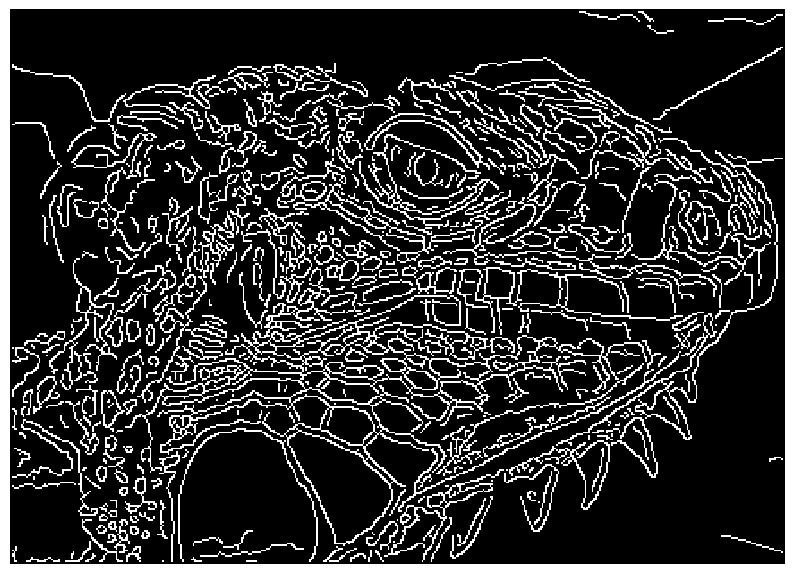

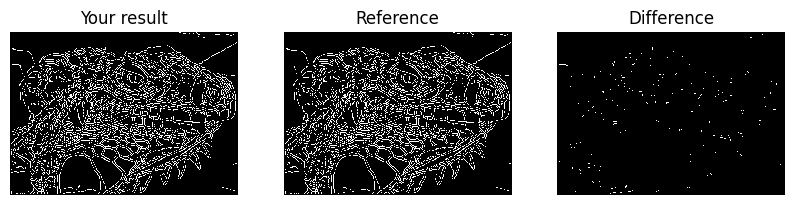

In [ ]:
# You should implement link_edges() before running this block
edges = link_edges(strong_edges, weak_edges)



plt.imshow(edges)
plt.axis('off')
plt.show()

plt.subplot(1, 3, 1)
plt.imshow(edges)
plt.axis('off')
plt.title('Your result')

plt.subplot(1, 3, 2)
reference = np.load('data/iguana_edge_tracking.npy')
plt.imshow(reference)
plt.axis('off')
plt.title('Reference')

plt.subplot(1, 3, 3)
plt.imshow(edges ^ reference)
plt.title('Difference')
plt.axis('off')
plt.show()

# ###
# plt.imshow(strong_edges)
# plt.axis('off')
# plt.show()

# plt.subplot(1, 2, 1)
# plt.imshow(weak_edges)
# plt.axis('off')
# plt.title('Your result')

# plt.subplot(1, 2, 2)
# plt.imshow(edges ^ reference)
# plt.title('Difference')
# plt.axis('off')
# plt.show()
# ###

### 1.6 Canny edge detector (20 points)

#### Implementation (10 points)
Implement **`canny`** in `edge.py` using the functions you have implemented so far. Test edge detector with different parameters.

Here is an example of the output in `data/iguana_edges.png`.

We provide a reference output and the difference between it and your result for debugging purposes.  If you notice your result is too different from the reference output, you should check your implementation.

(310, 433)


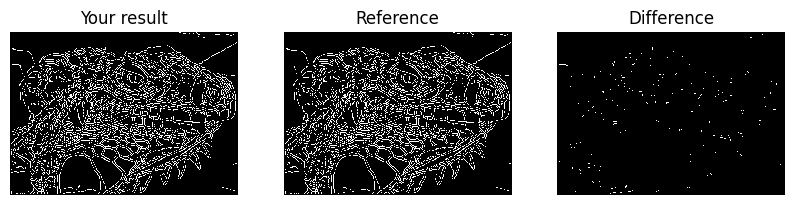

In [ ]:
# You should implement canny() before running this block
from edge import canny

# Load image
img = io.imread('data/iguana.png', as_gray=True)

# Run Canny edge detector
edges = canny(img, kernel_size=5, sigma=1.4, high=0.03, low=0.02)
print (edges.shape)

plt.subplot(1, 3, 1)
plt.imshow(edges)
plt.axis('off')
plt.title('Your result')


plt.subplot(1, 3, 2)
reference = np.load('data/iguana_canny.npy')
plt.imshow(reference)
plt.axis('off')
plt.title('Reference')

plt.subplot(1, 3, 3)
plt.imshow(edges ^ reference)
plt.title('Difference')
plt.axis('off')
plt.show()

#### Question (10 points)

**(a)(5 points)** Suppose that the Canny edge detector successfully detects an edge in an image. The edge is then rotated by θ, where the relationship between a point on the original edge $(x, y)$ and a point on the rotated edge $(x', y')$ is defined as

$$
x'=x\cos{\theta}\\
y'=x\sin{\theta}
$$

Will the rotated edge be detected using the same Canny edge detector? Provide either a mathematical proof or a counter example.

*-Hint: The detection of an edge by the Canny edge detector depends only on the magnitude of its derivative. The derivative at point (x, y) is determined by its components along the x and y directions. Think about how these magnitudes have changed because of the rotation.*

**Your Answer Here:** Write your solution in this markdown cell.

In original image, the magnitude of gradient:

$$G= \sqrt{G_x^2 + G_y^2} = |G_x|$$

In rotated image, the magnitude of gradient:


$$
\begin{align}
    G' &= \sqrt{G_{x'}^2 + G_{y'}^2} = \sqrt{G_{x}^2\cos^2\theta + G_{x}^2\sin^2\theta} = \sqrt{G_x^2} \\
    &= |G_x|
    \end{align}
$$

so the magnitude of the gradient in both images should be the same, so the edge will still be detected


**(b)(5 points)** After running the Canny edge detector on an image, you notice that long edges are broken into short segments separated by gaps. In addition, some spurious edges appear. For each of the two thresholds (low and high) used in hysteresis thresholding, explain how you would adjust the threshold (up or down) to address both problems. Assume that a setting exists for the two thresholds that produces the desired result. Briefly explain your answer.

**Your Answer Here:** Write your solution in this markdown cell.

We should decrease the low threshold and increase the high threshold.

By decreasing the low threshold, we can include more weak edge points and so that more points that are originally broken and caused segments will become edge points again.

By increasing the high threshold, less noise pixels which have higher gradient values can be consider as weak edge points instead of strong edge points, and are less likely to be included in the final edges.

---
## Part 2: Corner Detection (20 points)

In this section we will implement the Harris corner detection. Recall in the lecture that Harris corners are extracted from the corner response function:
$$
R= \lambda_1\lambda_2-k\cdot(\lambda_1+\lambda_2)^2
$$
where $0.04\leq k\leq 0.06$ is a parameter, $\lambda_1$ and $\lambda_2$ are the two eigenvalues of the $2\times 2$ structure tensor computed for each pixel $p$ (summed over a window $W$ centered at the pixel)
\begin{pmatrix}
\sum_{p\in W} I_x(p)^2   & \sum_{p\in W} I_x(p) I_y(p) \\
\sum_{p\in W} I_x(p) I_y(p) & \sum_{p\in W} I_y(p)^2
\end{pmatrix}
where $I_x$ is the image gradient along the $x$ dimension, and the $I_y$ is the image gradient along the $y$ dimension.

#### Implementation (20 points)

First, implement the function **`corner_response`** in `edge.py`.  Then run the following code to compute the corners of the input image.

Text(0.5, 1.0, 'Harris Response Map')

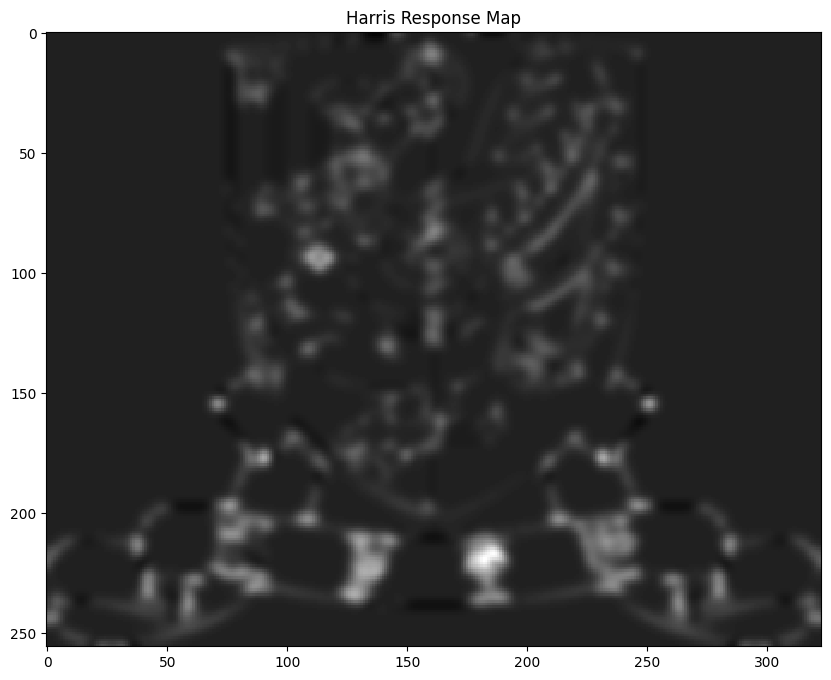

In [ ]:
# You should implement harris_corner_response() before running this block
from edge import harris_corner_response

img = io.imread('data/CUHKEmblem.png', as_gray=True)

# Binarize the image to make the corners more obvious
img = (img > 0.5) * 1.0

k = 0.06
hsz = 5 # Window size. 5 stands for a 11x11 window.
threshold = 0.05 # This hyperparameter is tunable for a better result

R = harris_corner_response(img, k, hsz)


plt.imshow(R, cmap='gray')
plt.title('Harris Response Map')

Second, implement the function **`non_maximum_suppression`** in `edge.py`. Then, apply non-maximum suppression for harris corner detection.

This function slides a window of the given size over the image, At each pixel,if the pixel at the center is the maximum value within the window, retain it. Else suppress it.

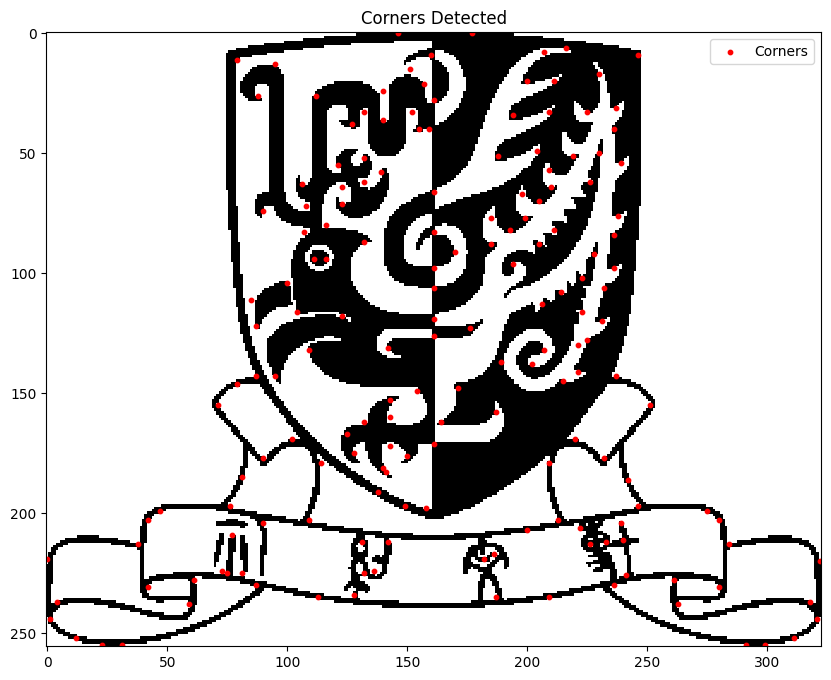

In [ ]:
# You should implement non_maximum_suppression() before running this block
from edge import non_maximum_suppression

R_nms = non_maximum_suppression(R, window_size=3)

# Thresholding to select corners
corners = np.argwhere(R_nms > np.max(R_nms) * threshold)

# Visualize the corners (in red dots)
plt.imshow(img, cmap='gray')
plt.scatter(corners[:, 1], corners[:, 0], s=10, color='red', label='Corners')
plt.title('Corners Detected')
plt.legend()
plt.show()





## Part 3: Lane Detection (15 points)

In this section we will implement a simple lane detection application using Canny edge detector and Hough transform.
Here are some example images of how your final lane detector will look like.

The algorithm can broken down into the following steps:
1. Detect edges using the Canny edge detector.
2. Extract the edges in the region of interest (a triangle covering the bottom corners and the center of the image).
3. Run Hough transform to detect lanes.



Here are some examples results of lane detection:



(-0.5, 1275.5, 721.5, -0.5)

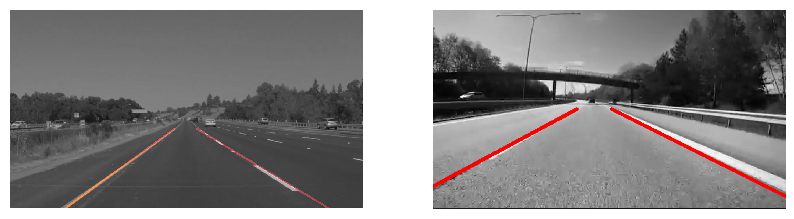

In [ ]:
plt.subplot(1,2,1)
plt.imshow(plt.imread('data/lane1.png'))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(plt.imread('data/lane2.png'))
plt.axis('off')

### 3.1 Edge detection
Lanes on the roads are usually thin and long lines with bright colors. Our edge detection algorithm by itself should be able to find the lanes pretty well. Run the code cell below to load the example image and detect edges from the image.

Make sure the canny function that you implemented in Part 1 is correct before you run codes in this part.

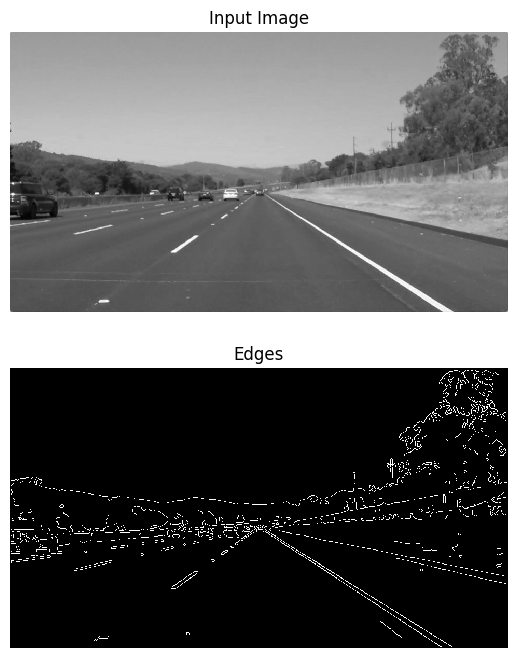

In [ ]:
from edge import canny

# Load image
img = io.imread('data/road.jpg', as_gray=True)

# Run Canny edge detector
edges = canny(img, kernel_size=5, sigma=1.4, high=0.03, low=0.02)

plt.subplot(211)
plt.imshow(img)
plt.axis('off')
plt.title('Input Image')

plt.subplot(212)
plt.imshow(edges)
plt.axis('off')
plt.title('Edges')
plt.show()

### 3.2 Extracting region of interest (ROI)
We can see that the Canny edge detector could find the edges of the lanes. However, we can also see that there are edges of other objects that we are not interested in. Given the position and orientation of the camera, we know that the lanes will be located in the lower half of the image. The code below defines a binary mask for the ROI and extract the edges within the region.

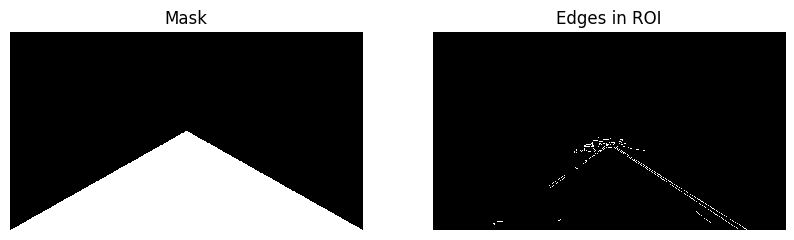

In [ ]:
H, W = img.shape

# Generate mask for ROI (Region of Interest)
mask = np.zeros((H, W))
for i in range(H):
    for j in range(W):
        if i > (H / W) * j and i > -(H / W) * j + H:
            mask[i, j] = 1

# Extract edges in ROI
roi = edges * mask

plt.subplot(1,2,1)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(roi)
plt.title('Edges in ROI')
plt.axis('off')
plt.show()

### 3.3 Fitting lines using Hough transform (15 points)
The output from the edge detector is still a collection of connected points. However, it would be more natural to represent a lane as a line parameterized as $y = ax + b$, with a slope $a$ and y-intercept $b$. We will use Hough transform to find parameterized lines that represent the detected edges.

In general, a straight line $y = ax + b$ can be represented as a point $(a, b)$ in the parameter space. However, this cannot represent vertical lines as the slope parameter will be unbounded. Alternatively, we parameterize a line using $\theta\in{[-\pi, \pi]}$ and $\rho\in{\mathbb{R}}$ as follows:

$$
\rho = x\cdot{cos\theta} + y\cdot{sin\theta}
$$

Using this parameterization, we can map every point in $xy$-space to a sine-like line in $\theta\rho$-space (or Hough space). We then accumulate the parameterized points in the Hough space and choose points (in Hough space) with highest accumulated values. A point in Hough space then can be transformed back into a line in $xy$-space.

Implement **`hough_transform`** in `edge.py`.

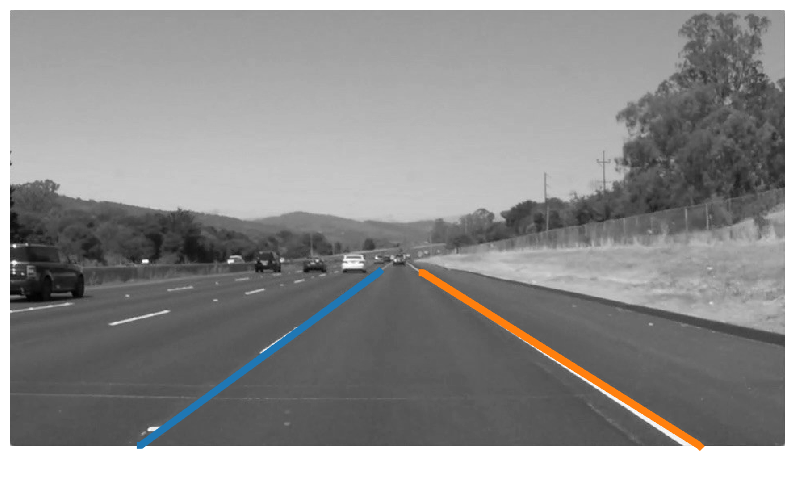

In [ ]:
from edge import hough_transform

# Perform Hough transform on the ROI
acc, rhos, thetas = hough_transform(roi)

# Coordinates for right lane
xs_right = []
ys_right = []

# Coordinates for left lane
xs_left = []
ys_left = []

for i in range(20):
    idx = np.argmax(acc)
    r_idx = idx // acc.shape[1]
    t_idx = idx % acc.shape[1]
    acc[r_idx, t_idx] = 0 # Zero out the max value in accumulator

    rho = rhos[r_idx]
    theta = thetas[t_idx]

    # Transform a point in Hough space to a line in xy-space.
    a = - (np.cos(theta)/np.sin(theta)) # slope of the line
    b = (rho/np.sin(theta)) # y-intersect of the line

    # Break if both right and left lanes are detected
    if xs_right and xs_left:
        break

    if a < 0: # Left lane
        if xs_left:
            continue
        xs = xs_left
        ys = ys_left
    else: # Right Lane
        if xs_right:
            continue
        xs = xs_right
        ys = ys_right

    for x in range(img.shape[1]):
        y = a * x + b
        if y > img.shape[0] * 0.6 and y < img.shape[0]:
            xs.append(x)
            ys.append(int(round(y)))

plt.imshow(img)
plt.plot(xs_left, ys_left, linewidth=5.0)
plt.plot(xs_right, ys_right, linewidth=5.0)
plt.axis('off')
plt.show()

---
**Acknowledgement**: This homework was developed based on a similar assignment from the computer vision course CS131 (Stanford) taught by Dr. Juan Carlos Niebles and  Prof. Ranjay Krishna.